# Data Visualizations for Behavioural Cloning 

In [1]:
import csv
import cv2
import textwrap
import warnings
import numpy as np
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Conv2D, MaxPooling2D, Dropout, Cropping2D, Convolution2D
import matplotlib.pyplot as plt
from IPython.display import SVG
%matplotlib inline

Using TensorFlow backend.


## Load Data

In [3]:
lines = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

In [4]:
# Helper Functions

def get_file_name(full_path):
    return ("./data/IMG/" + full_path.split('/')[-1])

def convertRGB(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def original(img):
    return img

def crop(image):
    # Original (160,320,3)
    return image[65:135,:]

def normalize(image):
    return (image/127.5 - 1)

def blur(img, kernel_size=5):
    return cv2.blur(img, (kernel_size, kernel_size))

def hsv(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    return image[:,:,1]


## Augmentation Functions

In [1]:
# Augmentations

def mirror(feature, label=None):
    if label == None:
        feature = cv2.flip(feature, 1)
        return feature
    else:
        feature = cv2.flip(feature, 1)
        label *= -1.0
    return feature, label

def get_random_translation(maximum_translation):
    return maximum_translation*np.random.uniform() - maximum_translation/2

def random_affine_transformation(image, angle, shear_range=200):
    rows, cols = image.shape[0:2]
    dx = np.random.randint(-shear_range, shear_range)
    random_point = [cols/2 + dx, rows/2]
    triangle1 = np.float32([[0,         rows],
                            [cols,      rows],
                            [cols/2,    rows/2]])
    triangle2 = np.float32([[0,    rows],
                            [cols, rows],
                            random_point])

    steering_correction = dx / (rows / 2) * 360 / (2 * np.pi * 25.0) / 6.0
    transf_matrix = cv2.getAffineTransform(triangle1, triangle2)
    image = cv2.warpAffine(image, transf_matrix, (cols, rows), borderMode=1)
    angle += steering_correction

    return image, angle

def translate(feature, label=None):
    if label == None:
        horizontal_translation = get_random_translation(maximum_translation=100)
        vertical_translation = 0

        transformation_matrix = np.float32([[1, 0, horizontal_translation], [0, 1, vertical_translation]])
        output_size = (320, 160)
        feature = cv2.warpAffine(feature, transformation_matrix, output_size)
        return feature
    
    else:
        horizontal_translation = get_random_translation(maximum_translation=100)
        vertical_translation = get_random_translation(maximum_translation=40)

        transformation_matrix = np.float32([[1, 0, horizontal_translation], [0, 1, vertical_translation]])
        output_size = (320, 160)
        feature = cv2.warpAffine(feature, transformation_matrix, output_size)
        label += horizontal_translation * 0.004  # we add 0.004 steering angle for every translated pixel
    return feature, label

def augment_data(feature,label):
    if np.random.normal(0.5, 0.5) < 0.6 :
        feature,label = mirror(feature,label)
    if np.random.normal(0.5, 0.5) < 0.6:
        feature,label = translate(feature,label)
    else:
        feature,label = random_affine_transformation(feature,label)
        
    return feature,label

In [70]:
# Plotting Functions

def steering_hist(y_train):
    fig, imtable = plt.subplots (1, 2, figsize = (15, 7))
    imtable[0].hist(y_train, bins=240,color='pink')
    imtable[1].hist(y_train, bins=240,log=True,color='purple')
    plt.show ()
    return None 

In [5]:
images = []
measurements = []
correction = 0.15

for line in lines:
    center_image = cv2.imread(get_file_name(line[0]))
    center_angle = float(line[3])
    images.extend([center_image])
    measurements.extend([center_angle])

    # if np.random.normal(0.5, 1) < 0.3 :
    #     left_image = cv2.imread(get_file_name(line[1]))
    #     left_angle = center_angle + correction
    #     images.extend([left_image])
    #     measurements.extend([left_angle])

    # if np.random.normal(0.5, 1) < 0.3 :
    #     right_image = cv2.imread(get_file_name(line[2]))
    #     right_angle = center_angle - correction
    #     images.extend([right_image])
    #     measurements.extend([right_angle])
    

print ("Converting Data")
# Convert to numpy array as that is what keras requires
X_train = np.array(images)
y_train = np.array(measurements)

print ("X_train shape: ",X_train.shape)
print ("y_train shape: ",y_train.shape)


Converting Data
X_train shape:  (8036, 160, 320, 3)
y_train shape:  (8036,)


# Steering Angles Through the Track

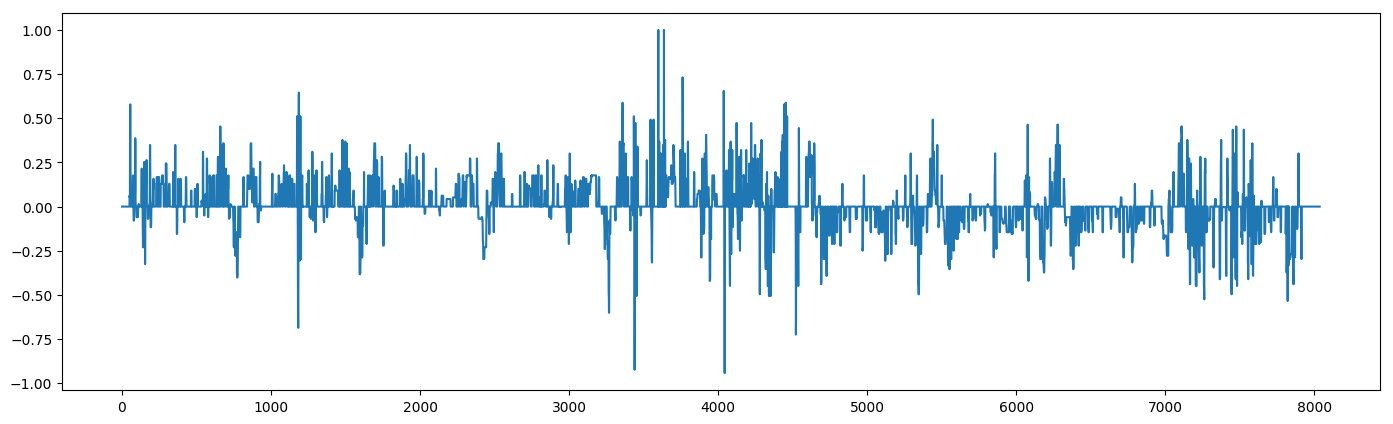

In [19]:
# Steering Angels Plot 
fig = plt.figure(figsize=(17, 5), dpi=100)
plt.plot(y_train)
plt.show()

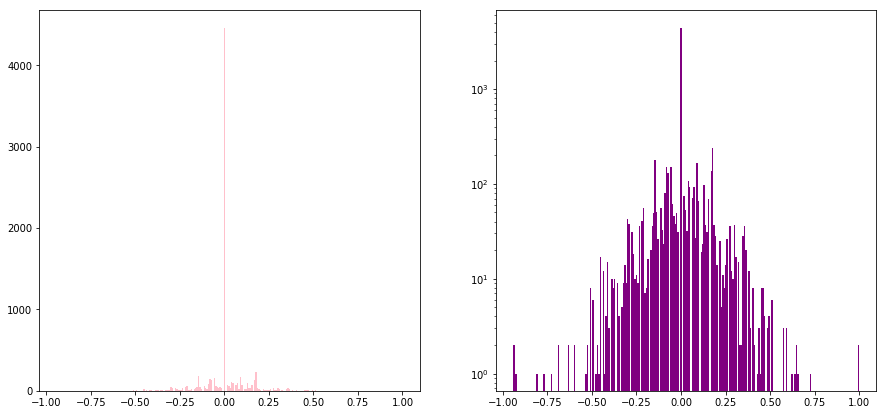

In [71]:
# Normal and Logged Graph 

steering_hist(y_train)


# Augmentation

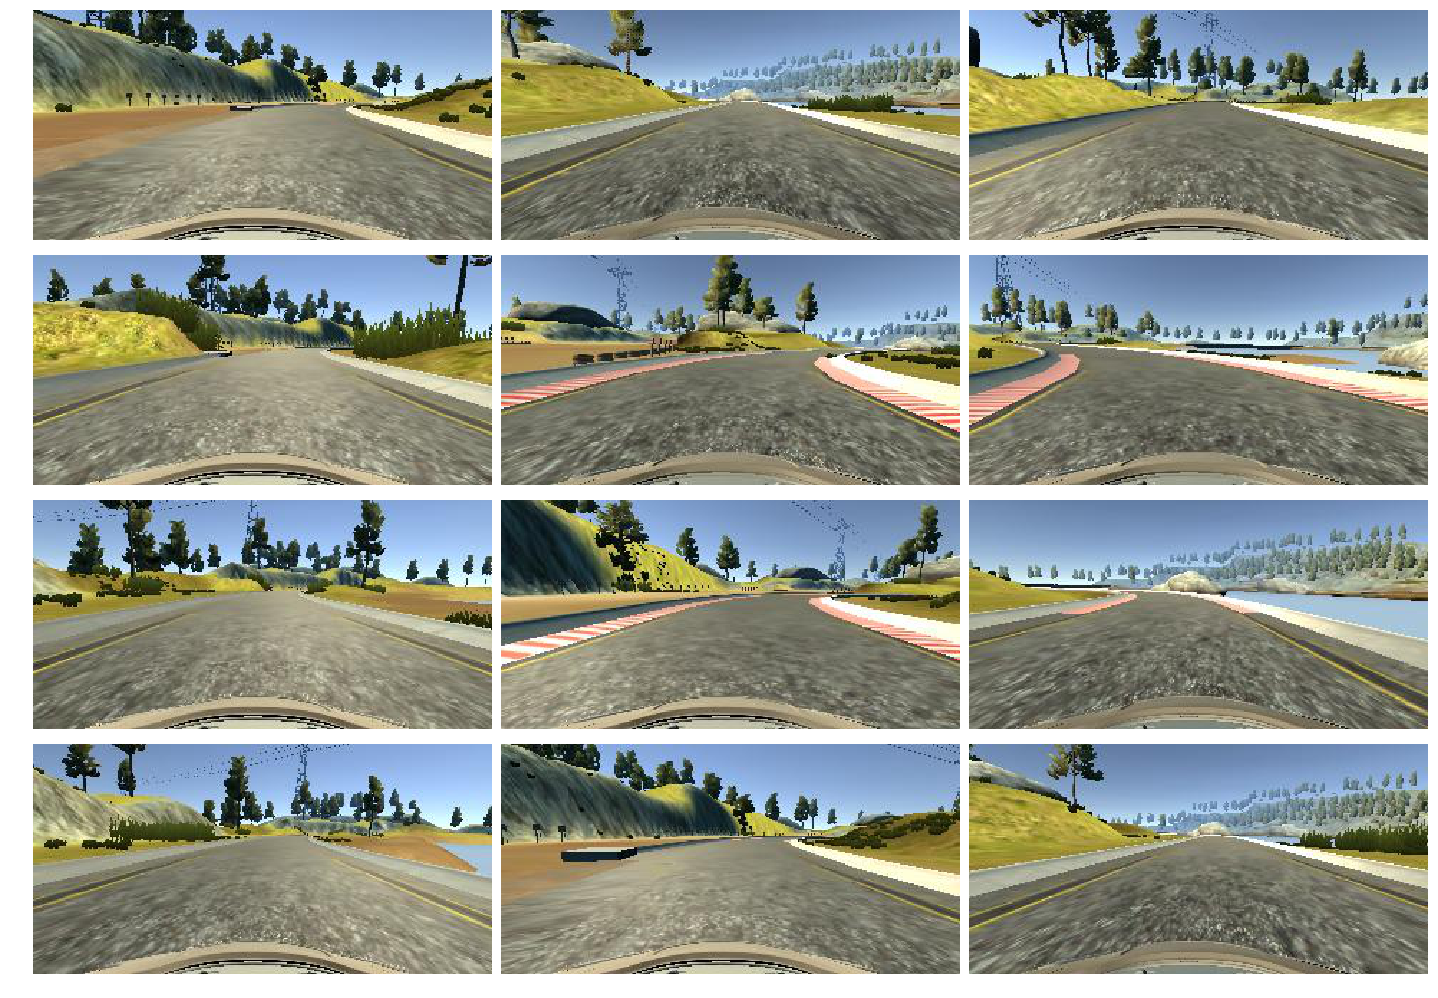

In [23]:
img1 = convertRGB(X_train[25])
img2 = convertRGB(X_train[130])
img3 = convertRGB(X_train[1100])
X_sample=[img1,img2,img3]




fig, axs = plt.subplots(5,3, figsize=(25, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace =0, wspace=.02)

q=0
for i, row in enumerate(axs):
    q += 500

    for j,ax in enumerate(row):
        q += 100
        ax.imshow(convertRGB(X_train[q]))
        ax.axis('off')

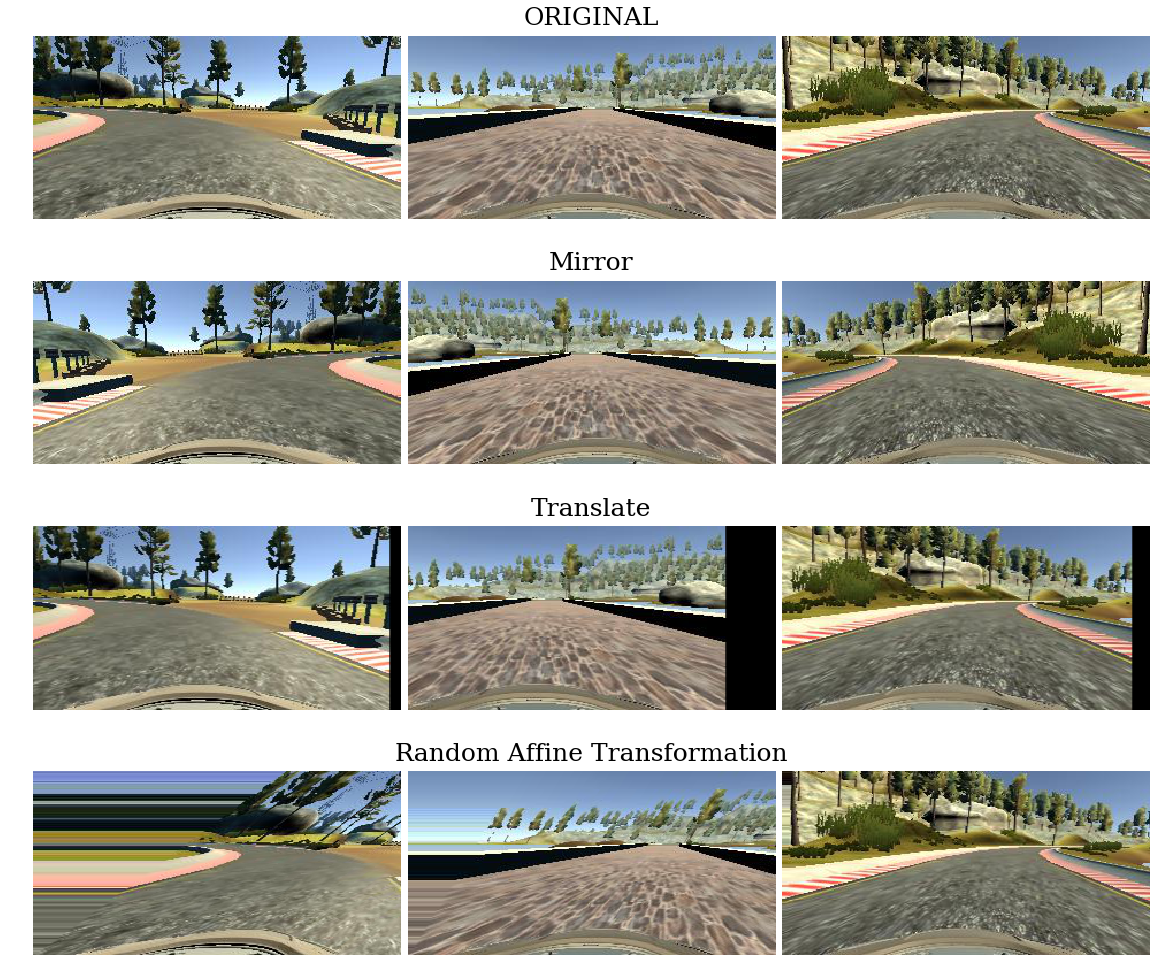

In [43]:
img1 = convertRGB(X_train[25])
img2 = convertRGB(X_train[130])
img3 = convertRGB(X_train[1100])
X_sample=[img1,img2,img3]

augmentations = [original,mirror,translate,random_affine_transformation]
aug_labels = ['ORIGINAL','Mirror','Translate','Random Affine Transformation']

fig, axs = plt.subplots(len(augmentations),3, figsize=(20, 4.5*len(augmentations)), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace =0.01, wspace=.02)

for i, row in enumerate(axs):
    axs[i][1].set_title(aug_labels[i], fontsize=25,verticalalignment = 'bottom',family='serif')
    for j,ax in enumerate(row):
        ax.imshow(augmentations[i](X_sample[j]))
        ax.axis('off')
        

# Preprocessing

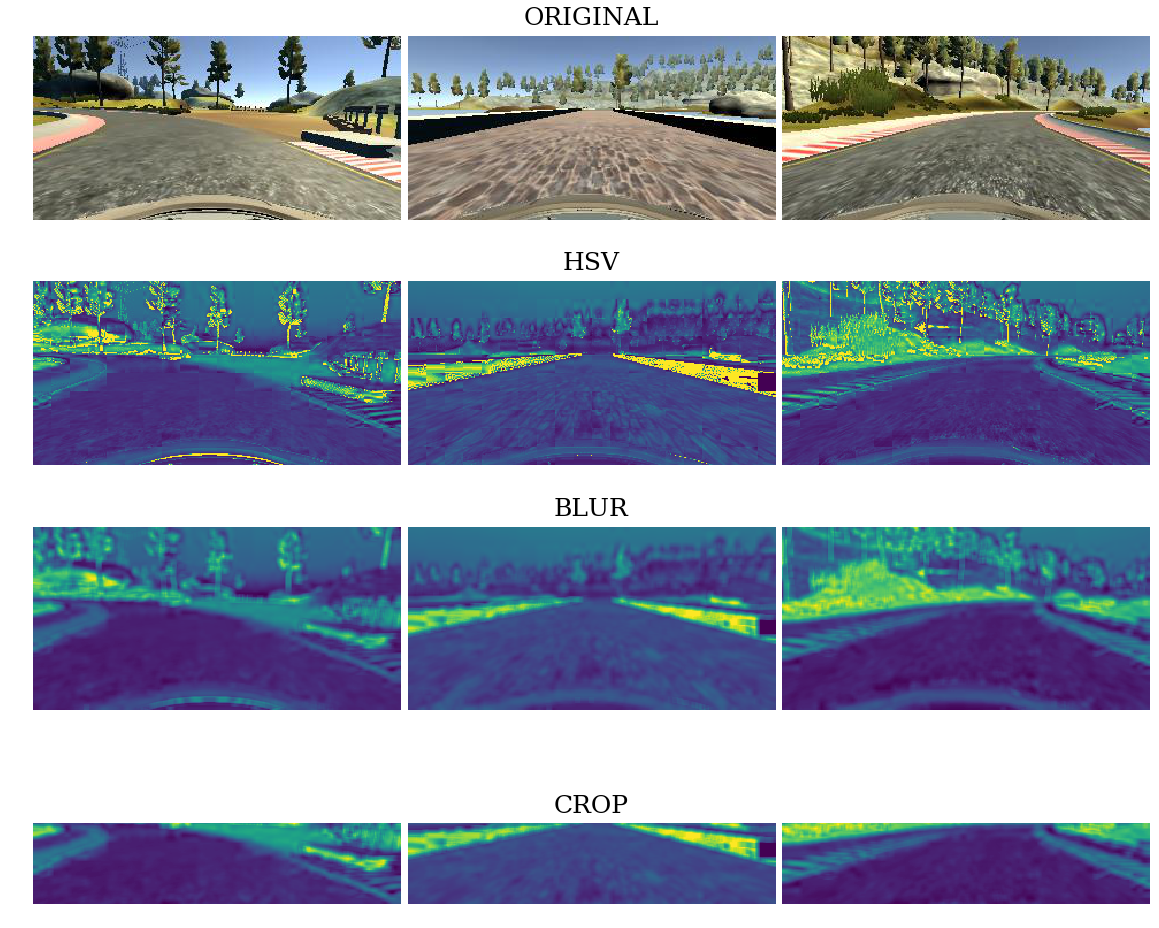

In [30]:
img1 = convertRGB(X_train[25])
img2 = convertRGB(X_train[130])
img3 = convertRGB(X_train[1100])
X_sample=[img1,img2,img3]

processing = [original,hsv,blur,crop]
proc_labels = ['ORIGINAL','HSV','BLUR','CROP']


fig, axs = plt.subplots(len(processing),3, figsize=(20, 4.5*len(processing)), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace =0.01, wspace=.02)

for i, row in enumerate(axs):
    axs[i][1].set_title(proc_labels[i], fontsize=25,verticalalignment = 'bottom',family='serif')
    for j,ax in enumerate(row):
        ax.imshow(processing[i](X_sample[j]))
        X_sample[j]= processing[i](X_sample[j])
        ax.axis('off')
        
       

## Apply Augmentation 

In [55]:
# X_train,y_train = [mirror(X_train[m],y_train[m]) for m in len(X_train)]
aug_img = []
aug_steering = []
for i in range(len(y_train)):
    img,steering = augment_data(X_train[i],y_train[i])
    aug_img.append(img)
    aug_steering.append(steering)
    
aug_img = np.asarray(aug_img)
aug_steering = np.asarray(aug_steering)
print ("X_train shape: ",aug_img.shape)
print ("y_train shape: ",aug_steering.shape)

X_train shape:  (8036, 160, 320, 3)
y_train shape:  (8036,)


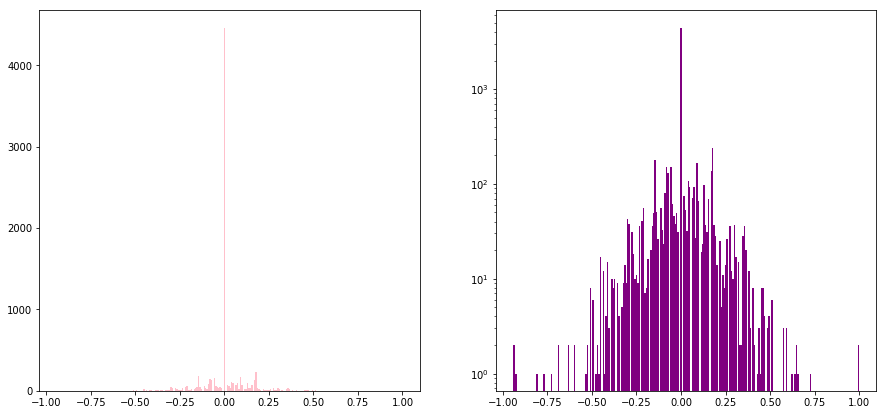

In [72]:
steering_hist(y_train)

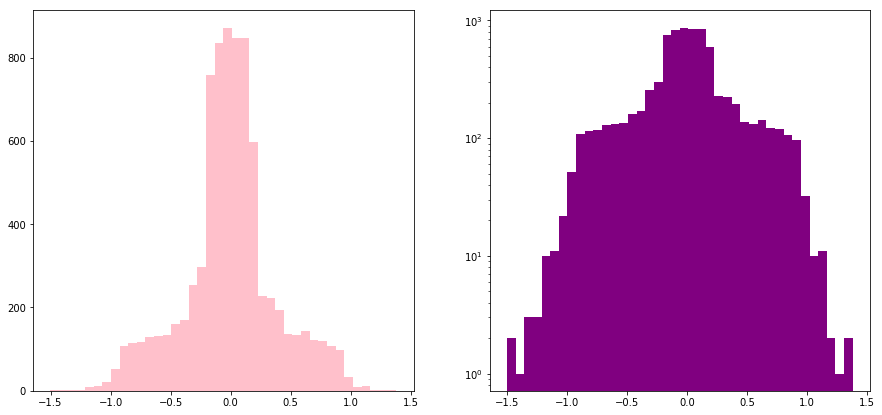

In [68]:
steering_hist(aug_steering)

In [58]:
aug_steeringnew = np.concatenate([aug_steering,y_train])

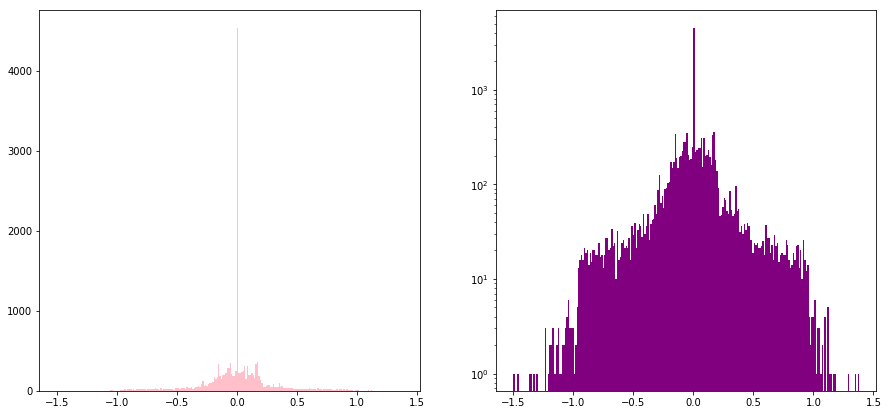

In [73]:
steering_hist(aug_steeringnew)


In [ ]:
print ("Shuffling Data")
shuffle(X_train, y_train)

In [2]:
dropout = 0.2
input_shape =(160,320,3)

model = Sequential()
model.add(Lambda(lambda x: x / 127.5 - 1., input_shape=input_shape))
model.add(Cropping2D(cropping=((65, 25), (0, 0))))
model.add(Conv2D(3, kernel_size=(1, 1), strides=(1, 1), activation='linear'))
model.add(Conv2D(24, kernel_size=(5, 5), strides=(2, 2), activation='relu'))
model.add(Conv2D(36, kernel_size=(5, 5), strides=(2, 2), activation='relu'))
model.add(Conv2D(48, kernel_size=(5, 5), strides=(2, 2), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(1164, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(100, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(50, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='linear'))

# Mean squared error
model.compile(loss='mse',optimizer='adam')
# model.fit(X_train,y_train,validation_split=0.2,shuffle=True, epochs=4)

# Save the model
# model.save('model.h5')
print ("model saved")

model saved


In [4]:
## Model Visualized
from keras.utils import plot_model

plot_model(model, to_file='model.png')